In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [5]:
#load dataset

# file_path = r'c:\Data\american_bankruptcy.xlsx'
# df = pd.read_excel(file_path)

df = pd.read_csv('american_bankruptcy.csv')
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [6]:
#Understanding the Dataset

def summary(df):
    print(f'data shape: {df.shape}')  
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values

    return summ

summary(df)

data shape: (78682, 21)


,data type,#missing,%missing,#unique,min,max
company_name,object,0,0.0,8971,NaN,NaN
status_label,object,0,0.0,2,NaN,NaN
year,int64,0,0.0,20,1999.0,2018.0
X1,float64,0,0.0,65895,-7.76,169662.0
X2,float64,0,0.0,65690,-366.645,374623.0
X3,float64,0,0.0,36010,0.0,28430.0
X4,float64,0,0.0,59060,-21913.0,81730.0
X5,float64,0,0.0,38898,0.0,62567.0
X6,float64,0,0.0,55550,-98696.0,104821.0
X7,float64,0,0.0,49577,-0.006,65812.0


According to the summary, the US Company Bankruptcy DataFrame has 78,682 rows and 21 columns. Here's how the data was analysed:

Data Types: The DataFrame contains columns with various data types, such as object, int64, and float64.

Missing Values: There are no missing values in any of the columns as indicated by the %missing column showing 0.0% missing values for all columns.

Unique Values: The number of unique values for each column varies. For instance, company_name has 8,971 unique values, status_label has 2 unique values, and other columns have different numbers of unique values.

Summary Statistics: The describe function provides statistical summary for numerical columns. It includes count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile or Q2), 75th percentile (Q3), and maximum values.

In [7]:
 #Creating a bankrupt label to mark companies as either "bankrupt" (1) or "not bankrupt" (0) 
 # based only on the most recent observation (year) for each company. - CJ 


df_bankrpt_data = df.copy() # creating a copy so that the original data is not overwritten
df_bankrpt_data['year'] = round(df['year'].astype(int), 0)

# Step 2: Recode the 'status_label' so that only the last observation in a panel is 'failed'
# Sort the dataset by company_name and year to ensure the panel is correctly ordered
df_bankrpt_data = df_bankrpt_data.sort_values(by=['company_name', 'year'])

# Identify the last observation for each panel
df_bankrpt_data['is_last'] = df_bankrpt_data.groupby('company_name')['year'].transform('max') == df_bankrpt_data['year']

# Recode 'status_label' based on whether it's the last observation
# df_bankrpt_data['status_label'] = df_bankrpt_data.apply(lambda row: 'failed' if row['is_last'] else 'alive', axis=1)

df_bankrpt_data['status_label_2'] = 'alive'
df_bankrpt_data.loc[(df_bankrpt_data['is_last']) & (df_bankrpt_data['status_label'] == 'failed'), 'status_label_2'] = 'failed'

# Step 3: Convert 'status_label' into a boolean called 'bankrupt'
df_bankrpt_data['bankrupt'] = df_bankrpt_data['status_label_2'].map({'alive': 0, 'failed': 1})

# Drop the 'is_last' and 'status_label' columns if no longer needed
df_bankrpt_data = df_bankrpt_data.drop(columns=['is_last', 'status_label', 'status_label_2'])

# Print the first 10 rows of the dataset
df_bankrpt_data.head(10)

,company_name,year,X1,X2,X3,X4,X5,X6,X7,X8,...,X10,X11,X12,X13,X14,X15,X16,X17,X18,bankrupt
0,C_1,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,...,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302,0
1,C_1,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.1180,...,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888,0
2,C_1,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.5928,...,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514,0
3,C_1,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.3295,...,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592,0
4,C_1,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.9071,...,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467,0
5,C_1,2004,474.542,598.172,27.950,61.774,255.477,15.453,127.121,522.6794,...,732.230,227.159,33.824,149.676,160.025,142.450,747.848,417.486,686.074,0
6,C_1,2005,624.454,704.081,29.222,91.877,323.592,35.163,136.272,882.6283,...,978.819,318.576,62.655,193.203,187.788,183.550,897.284,556.102,805.407,0
7,C_1,2006,645.721,837.171,32.199,118.907,342.593,58.660,181.691,1226.1925,...,1067.633,253.611,86.708,223.998,256.506,242.153,1061.169,573.390,942.262,0
8,C_1,2007,783.431,1080.895,39.952,168.522,435.608,75.144,202.472,747.5434,...,1362.010,507.918,128.570,304.024,218.499,318.184,1384.919,776.755,1216.397,0
9,C_1,2008,851.312,1110.677,40.551,166.080,477.424,78.651,227.300,571.5948,...,1377.511,392.984,125.529,313.299,254.418,385.851,1423.976,720.616,1257.896,0


In [8]:
df_bankrpt_data.shape
#df_bankrpt_data.dtypes


(78682, 21)

In [9]:
print(df_bankrpt_data[df_bankrpt_data['company_name'] == 'C_998'])

      company_name  year        X1        X2       X3       X4       X5  \
11886        C_998  1999  1468.808  1583.195   67.649  155.058  216.857   
11887        C_998  2000   574.528  1603.771   63.890   78.755  101.875   
11888        C_998  2001   799.499  1715.677   60.440  110.428  108.408   
11889        C_998  2002   762.905  1703.327   40.811 -115.120  149.848   
11890        C_998  2003   698.527  2208.338   44.504  -42.738   69.485   
11891        C_998  2004   799.923  1633.629   40.293   86.128   72.355   
11892        C_998  2005   993.099  1413.105   44.266  220.780   73.799   
11893        C_998  2006  2140.478  3305.921   61.000  425.696  307.915   
11894        C_998  2007  2757.500  4404.908   95.989  762.091  289.500   
11895        C_998  2008  2216.985  5393.694  126.133  590.782  440.096   
11896        C_998  2009  2357.921  4913.017  157.419  653.700  502.325   
11897        C_998  2010  1285.638  1744.622   76.452  442.358   67.528   
11898        C_998  2011 

In [10]:
bankruptcy_count_by_year = df_bankrpt_data[df_bankrpt_data['bankrupt'] == 1].groupby('year').size()
print(bankruptcy_count_by_year)


year
1999     3
2000     7
2001    10
2002    17
2003    29
2004    46
2005    40
2006    51
2007    59
2008    58
2009    23
2010    35
2011    25
2012    26
2013    28
2014    33
2015    33
2016    29
2017    21
2018    36
dtype: int64


In [11]:
# Original dataset Columns 

# x1 = current assets
# x2 = cogs
# x3 = depreciation and amortization
# x4 = ebitda
# x5 = inventory
# x6 = net income
# x7 = total receivables
# x8 = market value
# x9 = net sales
# x10 = total assets
# x11 = total long term debt
# x12 = ebit
# x13 = gross profit
# x14 = total current liabilities
# x15 = retained earnings
# x16 = total revenue
# x17 = total liabilities
# x18 = total operating expenses

#Altman ratios
#x1 = working capital / total assets
#x2 = retained earnings / total assets
#x3 = ebit / total assets
#x4 = market value of equity / book value of total liabilities
#x5 = sales / total assets
safe_ps = []
rupt_ps = []
correct = 0
for index, row in df_bankrpt_data.iterrows():
    x1 = (row['X1'] - row['X14']) / row['X10']
    x2 = row['X15'] / row['X10']
    x3 = row['X12'] / row['X10']
    x4 = row['X8'] / row['X17'] #??????
    x5 = row['X9'] / row['X10']
    zscore = 1.2*x1 + 1.4*x2 + 3.3*x3 + 0.6*x4 + x5
    p = stats.norm.cdf(zscore)
    if (row['bankrupt']) :
        rupt_ps.append(p)
        if (p < .5): correct = correct + 1
    else:
        safe_ps.append(p)
        if (p > .5): correct = correct + 1
avg_rupt = sum(rupt_ps) / len(rupt_ps)
avg_safe = sum(safe_ps) / len(safe_ps)
print('Average p for bankrupt company:',avg_rupt) 
print('Average p for not bankrupt company:',avg_safe)
print('Rate that the p was correct:', correct/len(df_bankrpt_data))

Average p for bankrupt company: 0.41369743974409917
Average p for not bankrupt company: 0.7972277554184969
Rate that the p was correct: 0.8151292544673496


In [14]:
safe_ps = []
rupt_ps = []
rupt_correct = 0
safe_correct = 0
tot_rupt = 0
tot_safe = 0
grouped = df_bankrpt_data.groupby('company_name')
for name, group in grouped:
    last_year = group['year'].max()
    bankrupt = group[group['year']==last_year]['bankrupt'].squeeze()
    for index, row in group.iterrows():
        x1 = (row['X1'] - row['X14']) / row['X10']
        x2 = row['X15'] / row['X10']
        x3 = row['X12'] / row['X10']
        x4 = row['X8'] / row['X17'] #??????
        x5 = row['X9'] / row['X10']
        zscore = 1.2*x1 + 1.4*x2 + 3.3*x3 + 0.6*x4 + x5
        p = stats.norm.cdf(zscore)
        if (p < .5):
            if(bankrupt and last_year - row['year'] <= 2):
                rupt_correct = rupt_correct + 1
                rupt_ps.append(p)
                tot_rupt+=1
            else:
                safe_ps.append(p)
                tot_safe+=1
        else: 
            if(bankrupt and last_year - row['year'] <= 2):
                rupt_ps.append(p)
                tot_rupt+=1
            else:
                safe_correct = safe_correct + 1
                safe_ps.append(p)
                tot_safe+=1
avg_rupt = sum(rupt_ps) / len(rupt_ps)
avg_safe = sum(safe_ps) / len(safe_ps)
correct = rupt_correct + safe_correct
print('Average p for company bankrupt within 2 years:',avg_rupt) 
print('Average p for company not bankrupt within 2 years:',avg_safe)
print('Rate that the p was correct:', correct/len(df_bankrpt_data))
print('Rate that p was correct for bankrupt companies:', rupt_correct/tot_rupt)
print('Rate that p was correct for safe companies:', safe_correct/tot_safe)

Average p for company bankrupt within 2 years: 0.5405811782114257
Average p for company not bankrupt within 2 years: 0.8000904486376293
Rate that the p was correct: 0.8110241224168171
Rate that p was correct for bankrupt companies: 0.43552036199095023
Rate that p was correct for safe companies: 0.8196557193748862


In [16]:
safe_ps_norm = []
rupt_ps_norm = []
safe_zs_norm = []
rupt_zs_norm = []
rupt_correct_norm = 0
safe_correct_norm = 0
false_safes_norm = 0
false_rupts_norm = 0
tot_rupt_norm = 0
tot_safe_norm = 0
rupt_grays_norm = 0
safe_grays_norm = 0

safe_ps_rece = []
rupt_ps_rece = []
safe_zs_rece = []
rupt_zs_rece = []
rupt_correct_rece = 0
safe_correct_rece = 0
false_safes_rece = 0
false_rupts_rece = 0
tot_rupt_rece = 0
tot_safe_rece = 0
rupt_grays_rece = 0
safe_grays_rece = 0
grouped = df_bankrpt_data.groupby('company_name')
for name, group in grouped:
    last_year = group['year'].max()
    bankrupt = group[group['year']==last_year]['bankrupt'].squeeze()
    for index, row in group.iterrows():
        x1 = (row['X1'] - row['X14']) / row['X10']
        x2 = row['X15'] / row['X10']
        x3 = row['X12'] / row['X10']
        x4 = row['X8'] / row['X17'] 
        x5 = row['X9'] / row['X10']
        zscore = 1.2*x1 + 1.4*x2 + 3.3*x3 + 0.6*x4 + x5
        p = stats.norm.cdf(zscore)
        if(bankrupt and last_year - row['year'] <= 2):
            if (row['year'] == 2008 or row['year'] == 2009):
                tot_rupt_rece+=1
                rupt_ps_rece.append(p)
                rupt_zs_rece.append(zscore)
                if (zscore < 1.81): rupt_correct_rece+=1
                elif (zscore > 2.99): false_safes_rece += 1
                else: rupt_grays_rece += 1
            else:
                tot_rupt_norm+=1
                rupt_ps_norm.append(p)
                rupt_zs_norm.append(zscore)
                if (zscore < 1.81): rupt_correct_norm+=1
                elif (zscore > 2.99): false_safes_norm += 1
                else: rupt_grays_norm += 1
        else:
            if (row['year'] == 2008 or row['year'] == 2009):
                tot_safe_rece+=1
                safe_ps_rece.append(p)
                safe_zs_rece.append(zscore)
                if (zscore < 1.81): false_rupts_rece +=1
                elif (zscore > 2.99): safe_correct_rece += 1
                else: safe_grays_rece += 1
            else:
                tot_safe_norm+=1
                safe_ps_norm.append(p)
                safe_zs_norm.append(zscore)
                if (zscore < 1.81): false_rupts_norm +=1
                elif (zscore > 2.99): safe_correct_norm += 1
                else: safe_grays_norm += 1
                
avg_rupt_z_rece = sum(rupt_zs_rece) / len(rupt_zs_rece)
avg_safe_z_rece = sum(safe_zs_rece) / len(safe_zs_rece)
avg_rupt_z_norm = sum(rupt_zs_norm) / len(rupt_zs_norm)
avg_safe_z_norm = sum(safe_zs_norm) / len(safe_zs_norm)
avg_rupt_z_tot = (sum(rupt_zs_rece)+sum(rupt_zs_norm))/(len(rupt_zs_rece)+len(rupt_zs_norm))
avg_safe_z_tot = (sum(safe_zs_rece)+sum(safe_zs_norm))/(len(safe_zs_rece)+len(safe_zs_norm))


print('Average z for company bankrupt within 2 years:',avg_rupt_z_tot) 
print('Average z for company not bankrupt within 2 years:',avg_safe_z_tot)
print('Average z for company bankrupt within 2 years during the recession:',avg_rupt_z_rece)
print('Average z for company bankrupt within 2 years outside the recession:',avg_rupt_z_norm)
print('Average z for company not bankrupt within 2 years during the recession:',avg_safe_z_rece)
print('Average z for company not bankrupt within 2 years outside the recession:',avg_safe_z_norm)
print('')
print('Rate that Altman was correct for bankrupt companies:', (rupt_correct_rece+rupt_correct_norm)/(tot_rupt_rece+tot_rupt_norm))
print('Rate that Altman was correct for safe companies:', (safe_correct_rece+safe_correct_norm)/(tot_safe_rece+tot_safe_norm))
print('Rate that Altman was correct for bankrupt companies during recession:', (rupt_correct_rece)/tot_rupt_rece)
print('Rate that Altman was correct for safe companies during recession:', (safe_correct_rece)/tot_safe_rece)
print('Rate that Altman was correct for bankrupt companies outside recession:', (rupt_correct_norm)/tot_rupt_norm)
print('Rate that Altman was correct for safe companies outside recession:', (safe_correct_norm)/tot_safe_norm)
print('')
print('False safe rate:', (false_safes_rece+false_safes_norm)/(tot_rupt_rece+tot_rupt_norm))
print('False bankrupt rate:', (false_rupts_rece+false_rupts_norm)/(tot_safe_rece+tot_safe_norm))
print('False safe rate during recession:', (false_safes_rece)/(tot_rupt_rece))
print('False safe rate outside recession:', (false_safes_norm)/(tot_rupt_norm))
print('False bankrupt rate during recession:', (false_rupts_rece)/(tot_safe_rece))
print('False bankrupt rate outside recession:', (false_rupts_norm)/(tot_safe_norm))
print('')
print('Rate that bankrupt company was in gray zone:', (rupt_grays_rece+rupt_grays_norm)/(tot_rupt_rece+tot_rupt_norm))
print('Rate that safe company was in the gray zone:', (safe_grays_rece+safe_grays_norm)/(tot_safe_rece+tot_safe_norm))
print('Rate that bankrupt company was in gray zone during recession:', (rupt_grays_rece)/(tot_rupt_rece))
print('Rate that safe company was in the gray zone during recession:', (safe_grays_rece)/(tot_safe_rece))
print('Rate that bankrupt company was in gray zone outside recession:', (rupt_grays_norm)/(tot_rupt_norm))
print('Rate that safe company was in the gray zone outside recession:', (safe_grays_norm)/(tot_safe_norm))

Average z for company bankrupt within 2 years: -13.932198647446729
Average z for company not bankrupt within 2 years: -8.202875991411522
Average z for company bankrupt within 2 years during the recession: -8.579694592895933
Average z for company bankrupt within 2 years outside the recession: -14.603391071855707
Average z for company not bankrupt within 2 years during the recession: -23.37455483885742
Average z for company not bankrupt within 2 years outside the recession: -6.58707506051365

Rate that Altman was correct for bankrupt companies: 0.7115384615384616
Rate that Altman was correct for safe companies: 0.47192968770314897
Rate that Altman was correct for bankrupt companies during recession: 0.7817258883248731
Rate that Altman was correct for safe companies during recession: 0.4229366473051466
Rate that Altman was correct for bankrupt companies outside recession: 0.7027371101209421
Rate that Altman was correct for safe companies outside recession: 0.47714750183424204

False safe 

Explaination of the above Output / Key Findings - CJ

1 -


### Computing Accuracy using LDA, QDA and logit with selected features (removing collinearities)

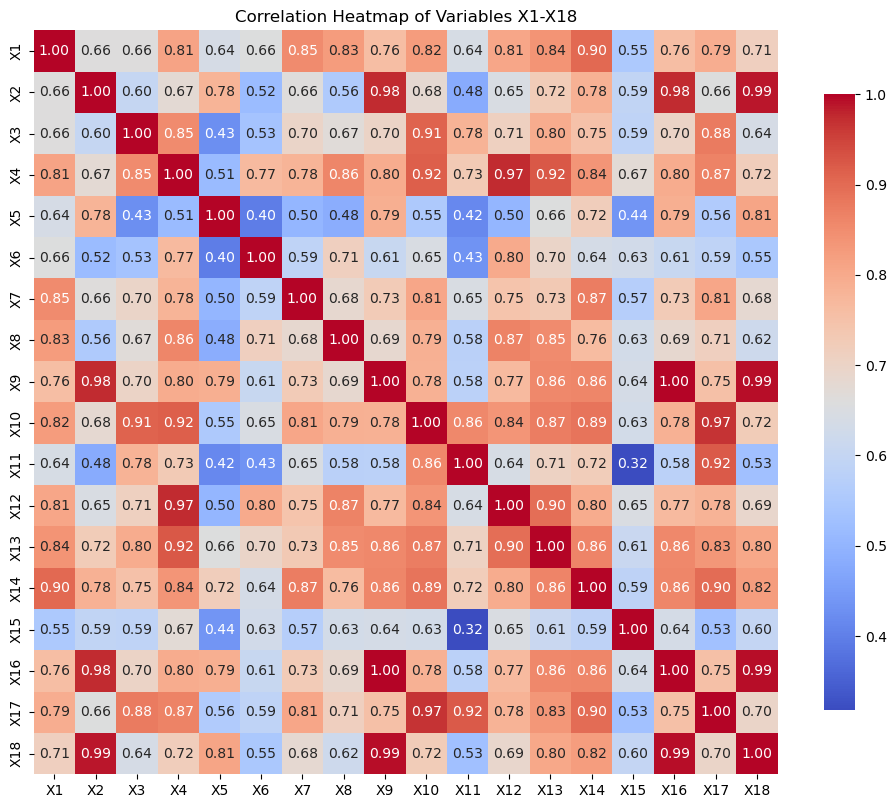

In [17]:
# Calculate the correlation matrix
corr_matrix = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                  'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .8})

# Customize the plot
plt.title('Correlation Heatmap of Variables X1-X18')
plt.show()

In [18]:
# Variance Inflation Factor (VIF) - If VIF is greater than 10, then there is potential multicollinearity
# Function to calculate VIF for each feature

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df_bankrpt_data):
    vif = pd.DataFrame()
    vif['Feature'] = df_bankrpt_data.columns
    vif['VIF'] = [variance_inflation_factor(df_bankrpt_data.values, i) for i in range(df_bankrpt_data.shape[1])]
    return vif

# 4. Calculate VIF for each feature
vif_data = calculate_vif(df_bankrpt_data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                             'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']])

# Print the VIF values
print(vif_data)

C:\Users\ashah\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


   Feature           VIF
0       X1  1.139031e+01
1       X2  1.958087e+14
2       X3  1.045768e+12
3       X4  3.900125e+09
4       X5  4.337048e+00
5       X6  3.097266e+00
6       X7  6.880050e+00
7       X8  6.756712e+00
8       X9           inf
9      X10  4.440371e+01
10     X11  1.667016e+01
11     X12  5.462219e+12
12     X13  3.532235e+13
13     X14  2.788218e+01
14     X15  2.957764e+00
15     X16           inf
16     X17  8.283362e+01
17     X18  2.649176e+14


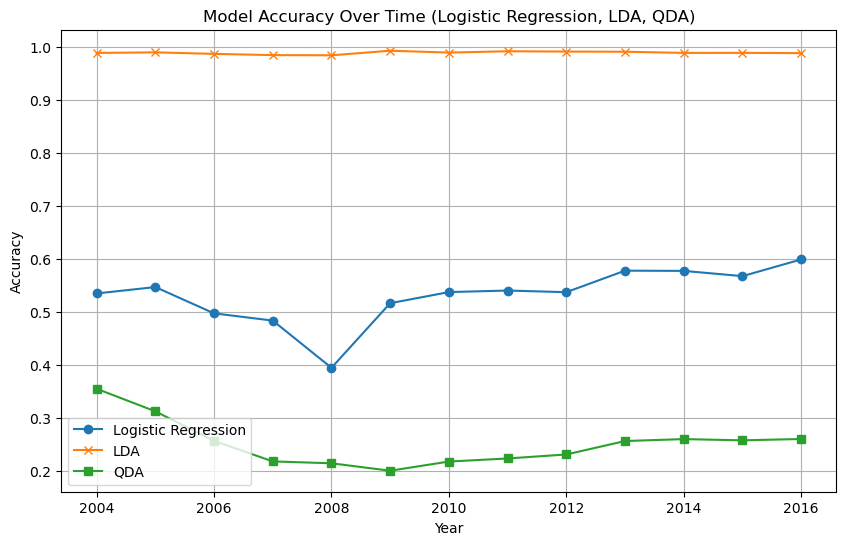

In [29]:
# Removing specific columns (X2, X4, X9, X16, X17, X18) as they are highly collinear
predictors = ['X1', 'X3', 'X5', 'X6', 'X7', 'X8', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15']

# Sort the data by company and year to maintain the time-seies structure
df_copy = df_bankrpt_data.sort_values(by=['company_name', 'year'])

# Initialize lists to store year-wise accuracy for each model
accuracy_lr = []
accuracy_lda = []
accuracy_qda = []

# Iterate through years (e.g., 2003 to 2015)
years = df_copy['year'].unique()
for year in range(2004, 2017):
    # Train on all data before the current year
    train_data = df_copy[df_copy['year'] < year]
    test_data = df_copy[df_copy['year'] == year]
    
    # Define features (X) and target (y)
    X_train = train_data[predictors]
    y_train = train_data['bankrupt']
    X_test = test_data[predictors]
    y_test = test_data['bankrupt']
    
    # Step 1: Logistic Regression
    model_lr = LogisticRegression(class_weight='balanced', random_state=42,max_iter=1000)
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    accuracy_lr.append((year, accuracy_score(y_test, y_pred_lr)))
    
    # Step 2: Linear Discriminant Analysis (LDA)
    model_lda = LinearDiscriminantAnalysis()
    model_lda.fit(X_train, y_train)
    y_pred_lda = model_lda.predict(X_test)
    accuracy_lda.append((year, accuracy_score(y_test, y_pred_lda)))
    
    # Step 3: Quadratic Discriminant Analysis (QDA)
    model_qda = QuadraticDiscriminantAnalysis()
    model_qda.fit(X_train, y_train)
    y_pred_qda = model_qda.predict(X_test)
    accuracy_qda.append((year, accuracy_score(y_test, y_pred_qda)))

# Convert lists to DataFrame for easier plotting
df_accuracy_lr = pd.DataFrame(accuracy_lr, columns=['year', 'accuracy_lr'])
df_accuracy_lda = pd.DataFrame(accuracy_lda, columns=['year', 'accuracy_lda'])
df_accuracy_qda = pd.DataFrame(accuracy_qda, columns=['year', 'accuracy_qda'])

# Step 4: Plot Accuracy Over Time for each model
plt.figure(figsize=(10, 6))
plt.plot(df_accuracy_lr['year'], df_accuracy_lr['accuracy_lr'], label='Logistic Regression', marker='o')
plt.plot(df_accuracy_lda['year'], df_accuracy_lda['accuracy_lda'], label='LDA', marker='x')
plt.plot(df_accuracy_qda['year'], df_accuracy_qda['accuracy_qda'], label='QDA', marker='s')

# Add title and labels
plt.title('Model Accuracy Over Time (Logistic Regression, LDA, QDA)')
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Computing accuracy based on new set of ratios - 1 

#### Current Ratio, Quick Ratio, Debt to Asset Ratio, Equity to Asset Ratio, Debt to Equity Ratio

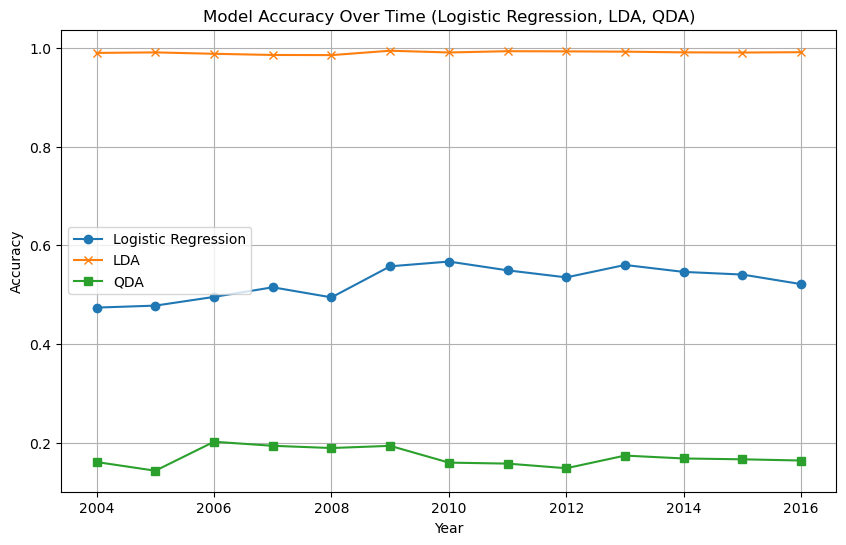

    year  accuracy_lr
0   2004     0.474011
1   2005     0.478002
2   2006     0.495640
3   2007     0.515091
4   2008     0.494685
5   2009     0.557574
6   2010     0.567172
7   2011     0.549388
8   2012     0.535151
9   2013     0.560276
10  2014     0.546233
11  2015     0.540847
12  2016     0.521467
    year  accuracy_lda
0   2004      0.989420
1   2005      0.990488
2   2006      0.987645
3   2007      0.985283
4   2008      0.984962
5   2009      0.993855
6   2010      0.990345
7   2011      0.992884
8   2012      0.992539
9   2013      0.991963
10  2014      0.990582
11  2015      0.990161
12  2016      0.990912
    year  accuracy_qda
0   2004      0.161454
1   2005      0.143876
2   2006      0.202519
3   2007      0.194313
4   2008      0.189785
5   2009      0.194229
6   2010      0.160276
7   2011      0.158269
8   2012      0.148924
9   2013      0.174512
10  2014      0.168664
11  2015      0.166965
12  2016      0.164525


In [33]:
# Create new columns based on financial ratios
df_bankrpt_data['current_ratio'] = df_bankrpt_data['X1'] / df_bankrpt_data['X14']
df_bankrpt_data['quick_ratio'] = (df_bankrpt_data['X1'] - df_bankrpt_data['X5']) / df_bankrpt_data['X14']
df_bankrpt_data['debt_to_asset_ratio'] = df_bankrpt_data['X17'] / df_bankrpt_data['X10']
df_bankrpt_data['equity_to_asset_ratio'] = df_bankrpt_data['X15'] / df_bankrpt_data['X10']
df_bankrpt_data['debt_to_equity_ratio'] = df_bankrpt_data['X17'] / df_bankrpt_data['X15']

predictors = ['current_ratio', 'quick_ratio','debt_to_asset_ratio', 'equity_to_asset_ratio', 'debt_to_equity_ratio']

# Sort the data by company and year to maintain the time-series structure
df_copy = df_bankrpt_data.sort_values(by=['company_name', 'year'])

# Initialize lists to store year-wise accuracy for each model
accuracy_lr = []
accuracy_lda = []
accuracy_qda = []

# Iterate through years (e.g., 2003 to 2015)
years = df_copy['year'].unique()
for year in range(2004, 2017):
    # Train on all data before the current year
    train_data = df_copy[df_copy['year'] < year]
    test_data = df_copy[df_copy['year'] == year]
    
    # Define features (X) and target (y)
    X_train = train_data[predictors]
    y_train = train_data['bankrupt']
    X_test = test_data[predictors]
    y_test = test_data['bankrupt']
    
    # Logistic Regression
    model_lr = LogisticRegression(class_weight='balanced', random_state=42,max_iter=1000)
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    accuracy_lr.append((year, accuracy_score(y_test, y_pred_lr)))
    
    # Linear Discriminant Analysis (LDA)
    model_lda = LinearDiscriminantAnalysis()
    model_lda.fit(X_train, y_train)
    y_pred_lda = model_lda.predict(X_test)
    accuracy_lda.append((year, accuracy_score(y_test, y_pred_lda)))
    
    # Quadratic Discriminant Analysis (QDA)
    model_qda = QuadraticDiscriminantAnalysis()
    model_qda.fit(X_train, y_train)
    y_pred_qda = model_qda.predict(X_test)
    accuracy_qda.append((year, accuracy_score(y_test, y_pred_qda)))

# Convert lists to DataFrame for easier plotting
df_accuracy_lr = pd.DataFrame(accuracy_lr, columns=['year', 'accuracy_lr'])
df_accuracy_lda = pd.DataFrame(accuracy_lda, columns=['year', 'accuracy_lda'])
df_accuracy_qda = pd.DataFrame(accuracy_qda, columns=['year', 'accuracy_qda'])

# Plot Accuracy Over Time for each model
plt.figure(figsize=(10, 6))
plt.plot(df_accuracy_lr['year'], df_accuracy_lr['accuracy_lr'], label='Logistic Regression', marker='o')
plt.plot(df_accuracy_lda['year'], df_accuracy_lda['accuracy_lda'], label='LDA', marker='x')
plt.plot(df_accuracy_qda['year'], df_accuracy_qda['accuracy_qda'], label='QDA', marker='s')

# Add title and labels
plt.title('Model Accuracy Over Time (Logistic Regression, LDA, QDA)')
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print(df_accuracy_lr)
print(df_accuracy_lda)
print(df_accuracy_qda)

### Computing accuracy based on new set of ratios - 2 

#### Working Capital to Assets, Retained Earnings to Assets, Market Value to liabilities, Sales to assets, Net Income to Assets, Debt to Equity, Cashflow to Debt

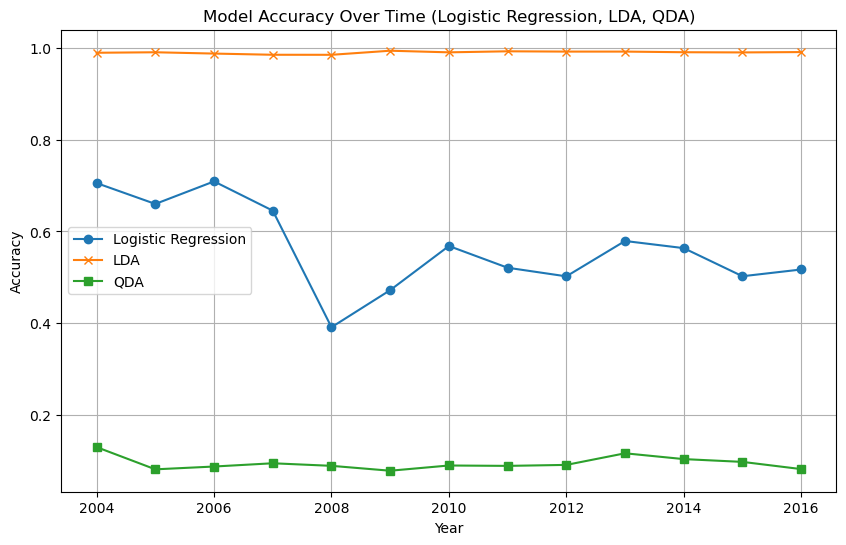

    year  accuracy_lr
0   2004     0.705382
1   2005     0.659929
2   2006     0.709060
3   2007     0.645298
4   2008     0.391237
5   2009     0.472081
6   2010     0.568276
7   2011     0.520922
8   2012     0.502152
9   2013     0.579219
10  2014     0.563642
11  2015     0.502385
12  2016     0.517079
    year  accuracy_lda
0   2004      0.989420
1   2005      0.990488
2   2006      0.987645
3   2007      0.985034
4   2008      0.984962
5   2009      0.993855
6   2010      0.990345
7   2011      0.992599
8   2012      0.991966
9   2013      0.991963
10  2014      0.990582
11  2015      0.990161
12  2016      0.990912
    year  accuracy_qda
0   2004      0.129945
1   2005      0.081570
2   2006      0.087694
3   2007      0.094787
4   2008      0.089188
5   2009      0.078547
6   2010      0.089931
7   2011      0.089098
8   2012      0.091248
9   2013      0.116533
10  2014      0.103881
11  2015      0.097794
12  2016      0.082106


In [34]:
df_bankrpt_data['working_capital_to_assets'] = (df_bankrpt_data['X1'] - df_bankrpt_data['X14']) / df_bankrpt_data['X10']
df_bankrpt_data['retained_earnings_to_assets'] = df_bankrpt_data['X15'] / df_bankrpt_data['X10']
df_bankrpt_data['market_value_to_liabilities'] = df_bankrpt_data['X8'] / df_bankrpt_data['X17']
df_bankrpt_data['sales_to_assets'] = df_bankrpt_data['X9'] / df_bankrpt_data['X10']
df_bankrpt_data['net_income_to_assets'] = df_bankrpt_data['X6'] / df_bankrpt_data['X10']
df_bankrpt_data['debt_to_equity'] = df_bankrpt_data['X17'] / df_bankrpt_data['X15']
df_bankrpt_data['cash_flow_to_debt'] = df_bankrpt_data['X6'] / df_bankrpt_data['X17']


predictors = ['working_capital_to_assets', 'retained_earnings_to_assets', 'market_value_to_liabilities', 'sales_to_assets',
              'net_income_to_assets', 'debt_to_equity', 'cash_flow_to_debt']

# Sort the data by company and year to maintain the time-series structure
df_copy = df_bankrpt_data.sort_values(by=['company_name', 'year'])

# Initialize lists to store year-wise accuracy for each model
accuracy_lr = []
accuracy_lda = []
accuracy_qda = []

# Iterate through years (e.g., 2003 to 2015)
years = df_copy['year'].unique()
for year in range(2004, 2017):
    # Train on all data before the current year
    train_data = df_copy[df_copy['year'] < year]
    test_data = df_copy[df_copy['year'] == year]
    
    # Define features (X) and target (y)
    X_train = train_data[predictors]
    y_train = train_data['bankrupt']
    X_test = test_data[predictors]
    y_test = test_data['bankrupt']
    
    # Logistic Regression
    model_lr = LogisticRegression(class_weight='balanced', random_state=42,max_iter=1000)
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    accuracy_lr.append((year, accuracy_score(y_test, y_pred_lr)))
    
    #Linear Discriminant Analysis (LDA)
    model_lda = LinearDiscriminantAnalysis()
    model_lda.fit(X_train, y_train)
    y_pred_lda = model_lda.predict(X_test)
    accuracy_lda.append((year, accuracy_score(y_test, y_pred_lda)))
    
    # Step 3: Quadratic Discriminant Analysis (QDA)
    model_qda = QuadraticDiscriminantAnalysis()
    model_qda.fit(X_train, y_train)
    y_pred_qda = model_qda.predict(X_test)
    accuracy_qda.append((year, accuracy_score(y_test, y_pred_qda)))

# Convert lists to DataFrame for easier plotting
df_accuracy_lr = pd.DataFrame(accuracy_lr, columns=['year', 'accuracy_lr'])
df_accuracy_lda = pd.DataFrame(accuracy_lda, columns=['year', 'accuracy_lda'])
df_accuracy_qda = pd.DataFrame(accuracy_qda, columns=['year', 'accuracy_qda'])

# Plot Accuracy Over Time for each model
plt.figure(figsize=(10, 6))
plt.plot(df_accuracy_lr['year'], df_accuracy_lr['accuracy_lr'], label='Logistic Regression', marker='o')
plt.plot(df_accuracy_lda['year'], df_accuracy_lda['accuracy_lda'], label='LDA', marker='x')
plt.plot(df_accuracy_qda['year'], df_accuracy_qda['accuracy_qda'], label='QDA', marker='s')

# Add title and labels
plt.title('Model Accuracy Over Time (Logistic Regression, LDA, QDA)')
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print(df_accuracy_lr)
print(df_accuracy_lda)
print(df_accuracy_qda)

Combining sets 1 & 2 and removing the overlapping ratios to see if it impacts the results

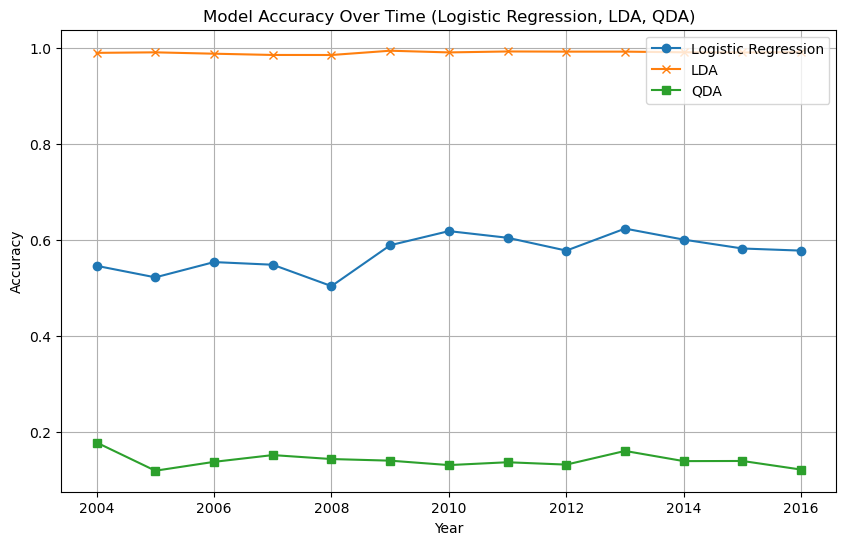

    year  accuracy_lr
0   2004     0.546228
1   2005     0.522235
2   2006     0.554021
3   2007     0.548516
4   2008     0.504019
5   2009     0.589100
6   2010     0.618483
7   2011     0.604611
8   2012     0.577905
9   2013     0.623708
10  2014     0.600742
11  2015     0.582290
12  2016     0.577875
    year  accuracy_lda
0   2004      0.989420
1   2005      0.990488
2   2006      0.987645
3   2007      0.985034
4   2008      0.984962
5   2009      0.993855
6   2010      0.990345
7   2011      0.992314
8   2012      0.991966
9   2013      0.991963
10  2014      0.990582
11  2015      0.990161
12  2016      0.990912
    year  accuracy_qda
0   2004      0.178473
1   2005      0.119857
2   2006      0.138324
3   2007      0.152407
4   2008      0.144153
5   2009      0.140796
6   2010      0.131586
7   2011      0.137489
8   2012      0.132568
9   2013      0.161022
10  2014      0.139840
11  2015      0.140131
12  2016      0.122219


In [35]:
df_bankrpt_data['working_capital_to_assets'] = (df_bankrpt_data['X1'] - df_bankrpt_data['X14']) / df_bankrpt_data['X10']
df_bankrpt_data['retained_earnings_to_assets'] = df_bankrpt_data['X15'] / df_bankrpt_data['X10']
df_bankrpt_data['market_value_to_liabilities'] = df_bankrpt_data['X8'] / df_bankrpt_data['X17']
df_bankrpt_data['sales_to_assets'] = df_bankrpt_data['X9'] / df_bankrpt_data['X10']
df_bankrpt_data['net_income_to_assets'] = df_bankrpt_data['X6'] / df_bankrpt_data['X10']
df_bankrpt_data['debt_to_equity'] = df_bankrpt_data['X17'] / df_bankrpt_data['X15']
df_bankrpt_data['cash_flow_to_debt'] = df_bankrpt_data['X6'] / df_bankrpt_data['X17']
df_bankrpt_data['current_ratio'] = df_bankrpt_data['X1'] / df_bankrpt_data['X14']
df_bankrpt_data['quick_ratio'] = (df_bankrpt_data['X1'] - df_bankrpt_data['X5']) / df_bankrpt_data['X14']

predictors = ['working_capital_to_assets', 'retained_earnings_to_assets', 'market_value_to_liabilities', 'sales_to_assets',
              'net_income_to_assets', 'debt_to_equity', 'cash_flow_to_debt', 'quick_ratio', 'current_ratio']

# Sort the data by company and year to maintain the time-series structure
df_copy = df_bankrpt_data.sort_values(by=['company_name', 'year'])

# Initialize lists to store year-wise accuracy for each model
accuracy_lr = []
accuracy_lda = []
accuracy_qda = []

# Iterate through years (e.g., 2003 to 2015)
years = df_copy['year'].unique()
for year in range(2004, 2017):
    # Train on all data before the current year
    train_data = df_copy[df_copy['year'] < year]
    test_data = df_copy[df_copy['year'] == year]
    
    # Define features (X) and target (y)
    X_train = train_data[predictors]
    y_train = train_data['bankrupt']
    X_test = test_data[predictors]
    y_test = test_data['bankrupt']
    
    # Logistic Regression
    model_lr = LogisticRegression(class_weight='balanced', random_state=42,max_iter=1000)
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    accuracy_lr.append((year, accuracy_score(y_test, y_pred_lr)))
    
    # Linear Discriminant Analysis (LDA)
    model_lda = LinearDiscriminantAnalysis()
    model_lda.fit(X_train, y_train)
    y_pred_lda = model_lda.predict(X_test)
    accuracy_lda.append((year, accuracy_score(y_test, y_pred_lda)))
    
    # Quadratic Discriminant Analysis (QDA)
    model_qda = QuadraticDiscriminantAnalysis()
    model_qda.fit(X_train, y_train)
    y_pred_qda = model_qda.predict(X_test)
    accuracy_qda.append((year, accuracy_score(y_test, y_pred_qda)))

# Convert lists to DataFrame for easier plotting
df_accuracy_lr = pd.DataFrame(accuracy_lr, columns=['year', 'accuracy_lr'])
df_accuracy_lda = pd.DataFrame(accuracy_lda, columns=['year', 'accuracy_lda'])
df_accuracy_qda = pd.DataFrame(accuracy_qda, columns=['year', 'accuracy_qda'])

# Plot Accuracy Over Time for each model
plt.figure(figsize=(10, 6))
plt.plot(df_accuracy_lr['year'], df_accuracy_lr['accuracy_lr'], label='Logistic Regression', marker='o')
plt.plot(df_accuracy_lda['year'], df_accuracy_lda['accuracy_lda'], label='LDA', marker='x')
plt.plot(df_accuracy_qda['year'], df_accuracy_qda['accuracy_qda'], label='QDA', marker='s')

# Add title and labels
plt.title('Model Accuracy Over Time (Logistic Regression, LDA, QDA)')
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print(df_accuracy_lr)
print(df_accuracy_lda)
print(df_accuracy_qda)

C:\Users\ashah\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


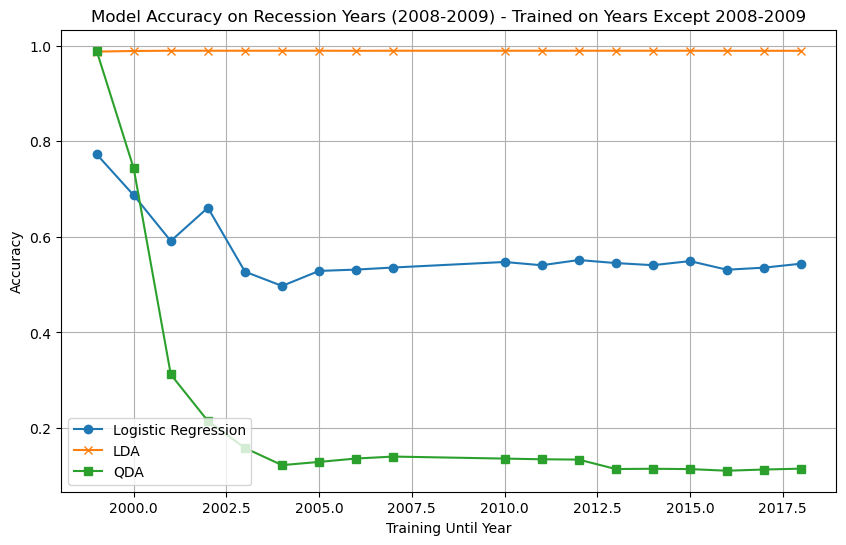

    train_until_year  accuracy_lr
0               1999     0.772763
1               2000     0.686974
2               2001     0.591316
3               2002     0.660921
4               2003     0.527105
5               2004     0.497237
6               2005     0.528684
7               2006     0.531447
8               2007     0.535789
9               2010     0.547368
10              2011     0.540526
11              2012     0.551447
12              2013     0.545132
13              2014     0.540658
14              2015     0.549211
15              2016     0.531184
16              2017     0.535526
17              2018     0.543816
    train_until_year  accuracy_lda
0               1999      0.987500
1               2000      0.988816
2               2001      0.989342
3               2002      0.989342
4               2003      0.989342
5               2004      0.989342
6               2005      0.989342
7               2006      0.989211
8               2007      0.989342
9   

In [38]:
# Define the years for the test set (recession period)
test_years = [2008, 2009]

# Filter the data for the test set (2008 and 2009)
test_data = df_copy[df_copy['year'].isin(test_years)]

# Filter the data for the training set (all years except 2008 and 2009)
train_data = df_copy[~df_copy['year'].isin(test_years)]  # Training set excludes 2008 and 2009

# Initialize lists to store accuracies for the models
accuracy_lr = []
accuracy_lda = []
accuracy_qda = []

# Train on all data except for 2008 and 2009 (i.e., time-series cross-validation on non-recession years)
for year in train_data['year'].unique():
    # Train on all data from before 2008 and after 2009 up to and including the current year
    X_train = train_data[train_data['year'] <= year][predictors]
    y_train = train_data[train_data['year'] <= year]['bankrupt']
    
    # Test on 2008 and 2009 (recession period)
    X_test = test_data[predictors]
    y_test = test_data['bankrupt']
    
    # Step 1: Logistic Regression
    model_lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    accuracy_lr.append((year, accuracy_score(y_test, y_pred_lr)))
    
    # Step 2: Linear Discriminant Analysis (LDA)
    model_lda = LinearDiscriminantAnalysis()
    model_lda.fit(X_train, y_train)
    y_pred_lda = model_lda.predict(X_test)
    accuracy_lda.append((year, accuracy_score(y_test, y_pred_lda)))
    
    # Step 3: Quadratic Discriminant Analysis (QDA)
    model_qda = QuadraticDiscriminantAnalysis()
    model_qda.fit(X_train, y_train)
    y_pred_qda = model_qda.predict(X_test)
    accuracy_qda.append((year, accuracy_score(y_test, y_pred_qda)))

# Convert accuracies to DataFrames for easier visualization
df_accuracy_lr = pd.DataFrame(accuracy_lr, columns=['train_until_year', 'accuracy_lr'])
df_accuracy_lda = pd.DataFrame(accuracy_lda, columns=['train_until_year', 'accuracy_lda'])
df_accuracy_qda = pd.DataFrame(accuracy_qda, columns=['train_until_year', 'accuracy_qda'])

# Plot Accuracy Over Time for each model trained until the respective year, tested on 2008-2009
plt.figure(figsize=(10, 6))
plt.plot(df_accuracy_lr['train_until_year'], df_accuracy_lr['accuracy_lr'], label='Logistic Regression', marker='o')
plt.plot(df_accuracy_lda['train_until_year'], df_accuracy_lda['accuracy_lda'], label='LDA', marker='x')
plt.plot(df_accuracy_qda['train_until_year'], df_accuracy_qda['accuracy_qda'], label='QDA', marker='s')

# Add title and labels
plt.title('Model Accuracy on Recession Years (2008-2009) - Trained on Years Except 2008-2009')
plt.xlabel('Training Until Year')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print(df_accuracy_lr)
print(df_accuracy_lda)
print(df_accuracy_qda)
